# Implementing GRAPE Algorithm
## First Order
### GRAPE calculation of control fields for cnot implementation
Ref: https://nbviewer.org/github/qutip/qutip-notebooks/blob/master/examples/control-grape-cnot.ipynb

In [1]:
import matplotlib.pyplot as plt
import time
import numpy as np
from qutip import *
from qutip.control import *
from qutip_qip.operations import cnot
from qutip import Options, QobjEvo

In [2]:
T = 2 * np.pi # Period
times = np.linspace(0, T, 500)

In [3]:
# Define the Operators
U = cnot()
R = 500
H_ops = [
    tensor(sigmax(), qeye(2)),
    tensor(sigmay(), qeye(2)),
    tensor(sigmaz(), qeye(2)),
    tensor(qeye(2), sigmax()),
    tensor(qeye(2), sigmay()),
    tensor(qeye(2), sigmaz()),
    tensor(sigmax(), sigmax()),
    tensor(sigmay(), sigmay()),
    tensor(sigmaz(), sigmaz())
]

H_labels = [
    r'$u_{1x}$', r'$u_{1y}$', r'$u_{1z}$',
    r'$u_{2x}$', r'$u_{1y}$', r'$u_{2z}$',
    r'$u_{xx}$', r'$u_{yy}$', r'$u_{zz}$',
    ]

In [4]:
# System Hamiltonian
H0 = 0 * np.pi * (tensor(sigmax(), qeye(2)) + tensor(qeye(2), sigmax()))

c_ops = []

#### GRAPE

In [5]:
from qutip.control.grape import plot_grape_control_fields, _overlap, grape_unitary #in this version cy_grape... was became grape...
from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar

In [6]:
# initialize control pulses with random values
u0 = np.array([np.random.rand(len(times)) * 2 * np.pi * 0.05 for _ in range(len(H_ops))])
# Smooth the initial controls
u0 =[np.convolve(np.ones(10)/10, u0[idx, :], mode='same') for idx in range(len(H_ops))]

# u_limits is limitaion of the control pulse for experimental reasons
u_limits = None #[0, 1 * 2 * pi]

# Regularization parameter for the control fields
alpha = None

In [7]:
result = grape_unitary(U, H0, H_ops, R, times, u_start=u0, eps=2*np.pi/T, phase_sensitive=False,
                          progress_bar=TextProgressBar(R))

10.0%. Run time:  18.38s. Est. time left: 00:00:02:45
20.0%. Run time:  36.39s. Est. time left: 00:00:02:25
30.0%. Run time:  54.22s. Est. time left: 00:00:02:06
40.0%. Run time:  72.91s. Est. time left: 00:00:01:49
50.0%. Run time:  91.12s. Est. time left: 00:00:01:31
60.0%. Run time: 111.44s. Est. time left: 00:00:01:14
70.0%. Run time: 131.28s. Est. time left: 00:00:00:56
80.0%. Run time: 150.68s. Est. time left: 00:00:00:37
90.0%. Run time: 170.11s. Est. time left: 00:00:00:18
Total run time: 189.88s


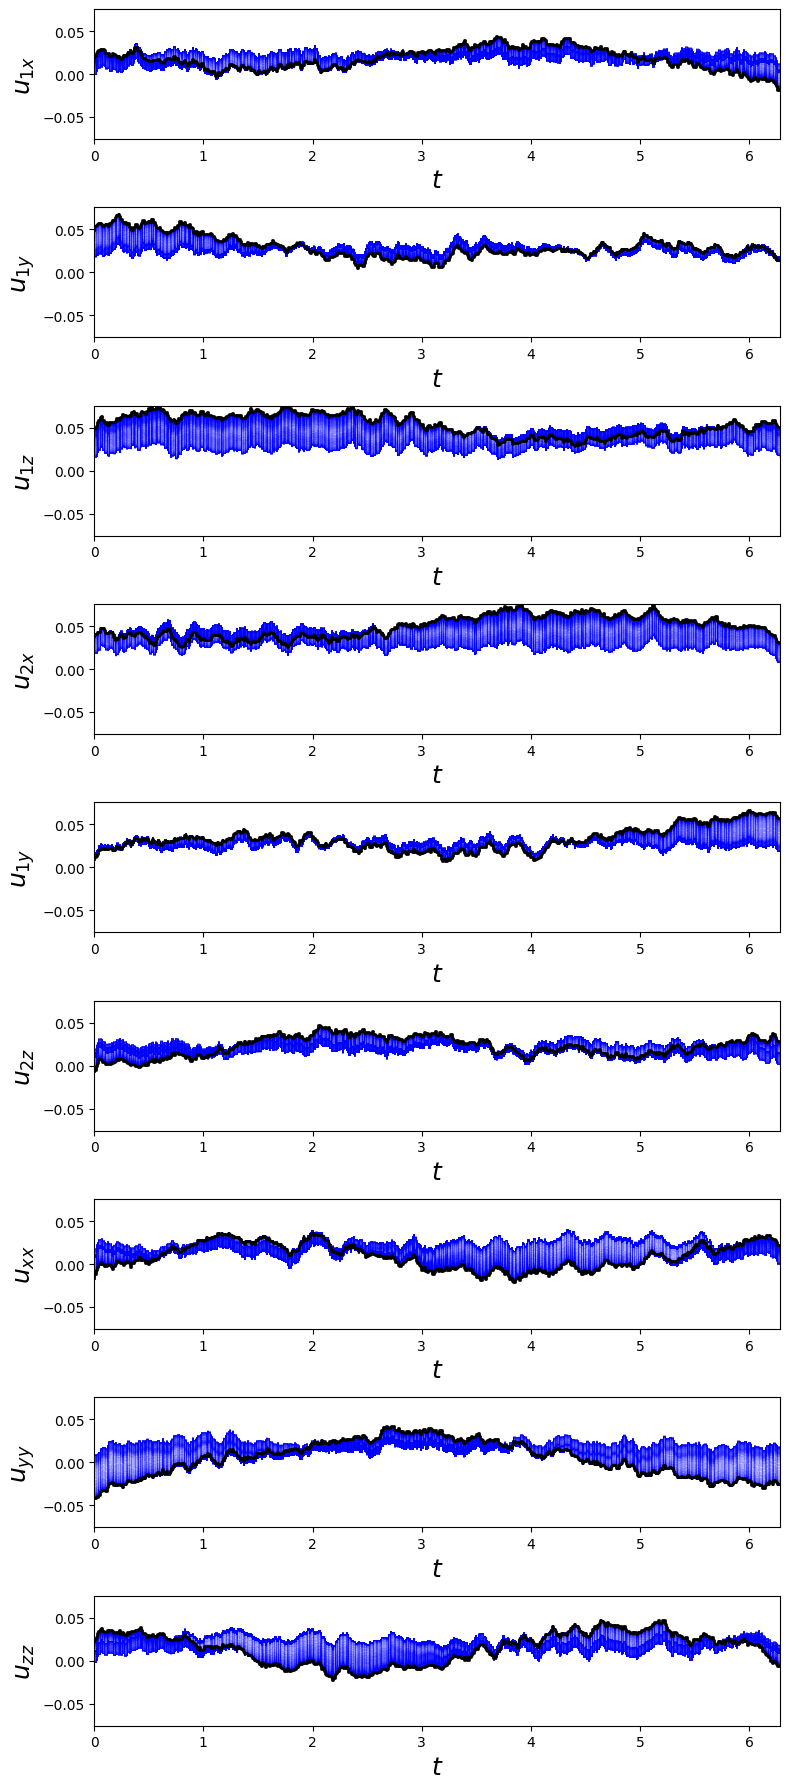

In [8]:
plot_grape_control_fields(times, result.u / (2 * np.pi), H_labels, uniform_axes=True);


Blue lines are iterated laser puse while optimizing. Black is the final pulse.

### Fidelity/Overlap

In [9]:
# Print Target Unitary
U

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]

In [10]:
# Print Result Unitary
result.U_f

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 7.06973264e-01+7.07239593e-01j -1.31113072e-04-2.04708488e-04j
   3.13244345e-04+6.14347573e-04j  5.38840906e-04+3.70759515e-04j]
 [ 2.05663449e-04+1.31880525e-04j  7.07125725e-01+7.07086626e-01j
  -5.48684721e-04-7.73255928e-04j -7.74719839e-04-3.91783676e-04j]
 [-3.70504305e-04-5.38832653e-04j  3.91828151e-04+7.74968459e-04j
   1.41173346e-04+4.74127367e-05j  7.06944921e-01+7.07267753e-01j]
 [-6.14183598e-04-3.12934203e-04j  7.73613024e-04+5.48339432e-04j
   7.07381265e-01+7.06831202e-01j -4.86543231e-05-1.41536923e-04j]]

In [11]:
# Standardize the result
result.U_f/result.U_f[0,0]

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 1.00000000e+00+0.00000000e+00j -2.37471612e-04-5.19951223e-05j
   6.55946936e-04+2.12788710e-04j  6.43162541e-04-1.18972673e-04j]
 [ 2.38669918e-04-5.22173792e-05j  9.99999602e-01-2.15969881e-04j
  -9.34783535e-04-1.58619862e-04j -8.24791935e-04+2.70932220e-04j]
 [-6.43021042e-04-1.18905080e-04j  8.25101199e-04+2.70765859e-04j
   1.33338074e-04-6.63239065e-05j  9.99999878e-01+3.99540972e-05j]
 [-6.55531472e-04+2.13139048e-04j  9.34731981e-04-1.59468596e-04j
   9.99999616e-01-5.77276487e-04j -1.34497951e-04-6.56526197e-05j]]

In [12]:
# Caluculate the fidelity and overlap
_overlap(U, result.U_f).real, abs(_overlap(U, result.U_f))**2

(0.7071062936852915, 0.9999986212417401)

Its almost same with the target unitary.
### Test numerical integration of GRAPE pulse

In [13]:
# Conver the Hamiltonian(Qobj) to QobjEvo
H_t_evo = QobjEvo(result.H_t, tlist=times)

In [14]:
# Check the Hamiltonian
H_t_evo

QobjEvo: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, superrep = None, isconstant = False, num_elements = 10

In [15]:
U_f_num = propagator(H_t_evo, times[-1], [], options=Options(nsteps=5000), args={})
U_f_num

C:\Users\Issei\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 7.07217863e-01+7.06985434e-01j -1.64889154e-03-1.37799620e-03j
   2.39191596e-03+1.20381342e-03j -1.12240062e-03+1.18835286e-03j]
 [ 1.37303148e-03+1.65423275e-03j  7.07008509e-01+7.07196187e-01j
   1.35890811e-04-2.27362598e-03j -1.17833666e-04+1.66559330e-03j]
 [-1.18829267e-03+1.12820725e-03j -1.66887837e-03+1.15639984e-04j
  -1.89221482e-03-1.60755239e-03j  7.07064940e-01+7.07140476e-01j]
 [-1.20261388e-03-2.38903385e-03j  2.27241425e-03-1.30772405e-04j
   7.07115666e-01+7.07084875e-01j  1.61398919e-03+1.89287663e-03j]]

In [16]:
U_f_num / U_f_num[0,0]

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 1.00000000e+00+0.j         -2.14037981e-03+0.0001912j
   2.54272109e-03-0.0008397j   4.63670664e-05+0.00163397j]
 [ 2.14058186e-03+0.00019919j  1.00000094e+00+0.00029706j
  -1.51133794e-03-0.00170405j  1.09423199e-03+0.00126126j]
 [-4.27563275e-05+0.00163802j -1.09852073e-03+0.00126167j
  -2.47476011e-03+0.00020088j  1.00000146e+00+0.00021777j]
 [-2.53955895e-03-0.00083935j  1.51465971e-03-0.00169907j
   9.99998028e-01+0.00014258j  2.47971412e-03+0.00019761j]]

In [17]:
_overlap(result.U_f, U_f_num).real, abs(_overlap(result.U_f, U_f_num))**2

(0.9999934823222033, 0.9999869646868867)

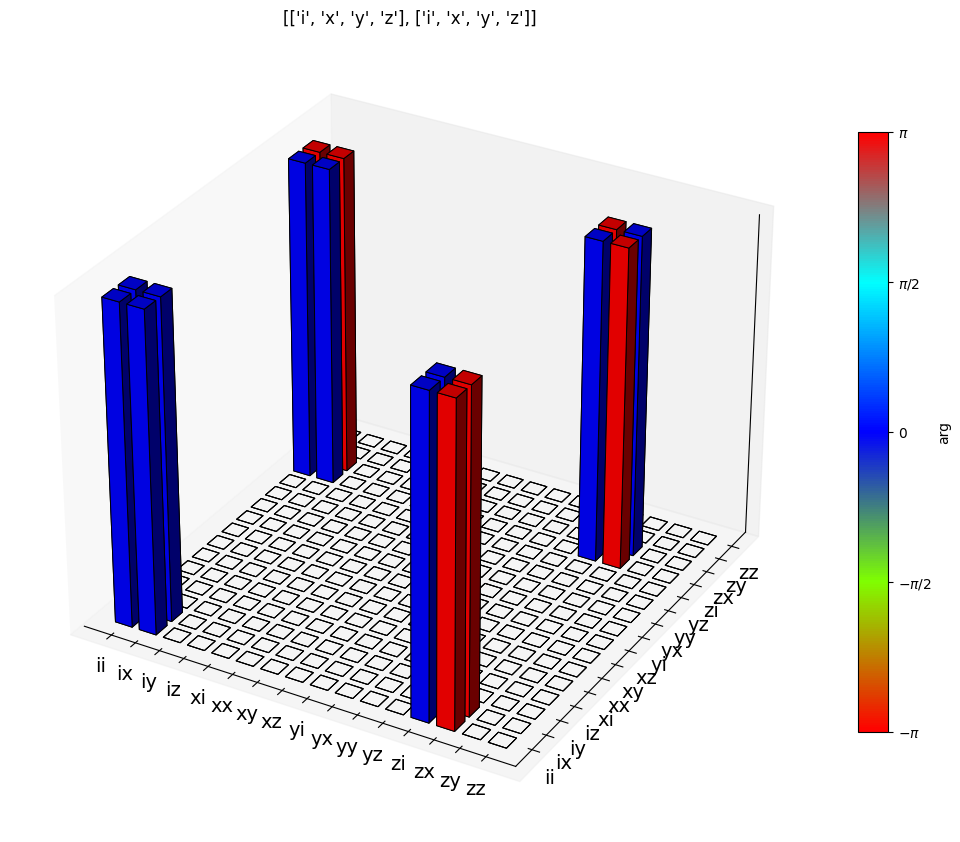

In [18]:
op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()]] * 2
op_label = [["i", "x", "y", 'z']] * 2

fig = plt.figure(figsize=(12,8))

U = cnot()

U_i_s = to_super(U)

chi = qpt(U_i_s, op_basis)

fig = qpt_plot_combined(chi, op_label, op_label, fig=fig, threshold=0.001)

plt.show()

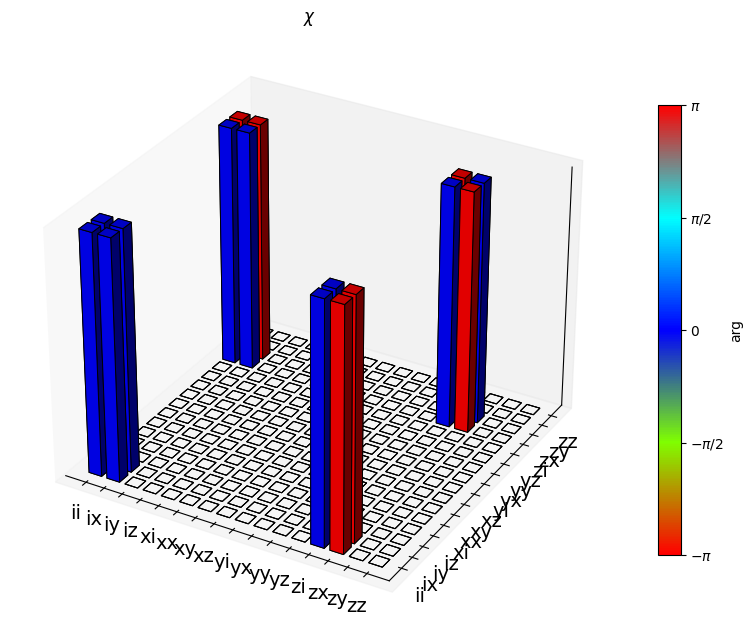

In [19]:
fig = plt.figure(figsize=(12,6))

U_f_s = to_super(result.U_f)

chi = qpt(U_f_s, op_basis)

fig = qpt_plot_combined(chi, op_label, fig=fig, threshold=0.001)


In [20]:
from qutip.ipynbtools import version_table

version_table()